<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_TL3_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Transfer Learning Scaling Up

In [16]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Model, Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.layers import RandomFlip, RandomHeight, RandomRotation, RandomWidth, RandomZoom
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory

## Setup

In [3]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-darkgrid')

### Constantes

In [12]:
SEMENTE = 2008193

DIR_TREINO_10 = '101_food_classes_10_percent/train'
DIR_TESTE     = '101_food_classes_10_percent/test'

TAMANHO_LOTE = 32
FORMATO_IMAGEM = (224, 224)
MODO_CLASSE = 'categorical'

CAMINHO_CHECKPOINT = 'checkpoints/scaling_up'

FORMATO_ENTRADA = FORMATO_IMAGEM + (3,)
ATIVACAO = 'softmax'

PERDA = 'categorical_crossentropy'
METRICAS = ['accuracy']

# OTIMIZADOR = 'Adam'
# APRENDIZADO = 0.001

ITERACOES = 5

### Funções

In [5]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-24 18:21:38--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4971 (4.9K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   4.85K  --.-KB/s    in 0s      

2023-01-24 18:21:38 (68.8 MB/s) - ‘funcoes.py’ saved [4971/4971]



In [6]:
from funcoes import criar_callback_tensorboard, grafico_historico_por_iteracao, grafico_historicos_complementares, unzip_data, walk_through_dir

## Dados

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data('101_food_classes_10_percent.zip')

--2023-01-24 18:21:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.96.128, 108.177.127.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.96.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  41.3MB/s    in 40s     

2023-01-24 18:22:18 (38.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [8]:
# walk_through_dir('101_food_classes_10_percent')

### Importando os dados e tranformando-os em lotes

In [9]:
dados_treino_10 = image_dataset_from_directory(directory=DIR_TREINO_10,
                                               batch_size=TAMANHO_LOTE,
                                               image_size=FORMATO_IMAGEM,
                                               label_mode=MODO_CLASSE,
                                               seed=SEMENTE)

dados_teste = image_dataset_from_directory(directory=DIR_TESTE,
                                           batch_size=TAMANHO_LOTE,
                                           image_size=FORMATO_IMAGEM,
                                           label_mode=MODO_CLASSE,
                                           seed=SEMENTE)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [11]:
rotulos = dados_treino_10.class_names
# rotulos

## Pré-modelagem

### Callback ModelCheckpoint

In [15]:
callback_checkpoint = ModelCheckpoint(filepath=CAMINHO_CHECKPOINT,
                                      save_weights_only = True,
                                      save_best_only = True,
                                      save_freq='epoch',
                                      monitor='val_accuracy',
                                      verbose=1)

### Expansão dos dados

In [17]:
expansao_dados = Sequential(name='expansao_dados')

expansao_dados.add(RandomFlip('horizontal'))
expansao_dados.add(RandomHeight(0.2))
expansao_dados.add(RandomRotation(0.2))
expansao_dados.add(RandomWidth(0.2))
expansao_dados.add(RandomZoom(0.2))

### Modelo-base

In [18]:
modelo_base = EfficientNetB0(include_top=False)
modelo_base.trainable = False

16705208/16705208 [==============================] - 1s 0us/step


## Modelo 10% expandido

In [19]:
entradas = Input(shape=FORMATO_ENTRADA, name='camada_entrada')

# Há um bug na versão 2.8 do TensorFlow que faz necessário forçar o treinamento para que a expansão dos dados funcione.
expandidos = expansao_dados(entradas, training=True)

camadas = modelo_base(expandidos, training=False)
camadas = GlobalAveragePooling2D(name='agrupamento_media_global')(camadas)

saidas = Dense(len(rotulos), activation=ATIVACAO, name='camada_saida')(camadas)

modelo = Model(inputs=entradas, outputs=saidas, name='Modelo')

modelo.compile(loss=PERDA,
               optimizer=Adam(),
               metrics=METRICAS)

In [20]:
historico = modelo.fit(dados_treino_10,
                       epochs=ITERACOES,
                       steps_per_epoch=len(dados_treino_10),
                       validation_data=dados_teste,
                       validation_steps=int(0.15 + len(dados_teste)), # Apenas 15% da base de teste
                       callbacks=[criar_callback_tensorboard(diretorio='scaling_up',
                                                             experimento='modelo_10_expandido'),
                                  callback_checkpoint],
                       verbose=1)

Salvando log TensorBoard em: 'scaling_up/modelo_10_extendido/20230124-185254'.
Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.4140 - accuracy: 0.2712
Epoch 1: val_accuracy improved from -inf to 0.43596, saving model to checkpoints/scaling_up
237/237 [==============================] - 254s 1s/step - loss: 3.4140 - accuracy: 0.2712 - val_loss: 2.5076 - val_accuracy: 0.4360
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.2411 - accuracy: 0.4916
Epoch 2: val_accuracy improved from 0.43596 to 0.49956, saving model to checkpoints/scaling_up
237/237 [==============================] - 170s 717ms/step - loss: 2.2411 - accuracy: 0.4916 - val_loss: 2.0825 - val_accuracy: 0.4996
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.8646 - accuracy: 0.5578
Epoch 3: val_accuracy improved from 0.49956 to 0.51644, saving model to checkpoints/scaling_up
237/237 [==============================] - 149s 627ms/step - loss: 1.8646 - accuracy: 0

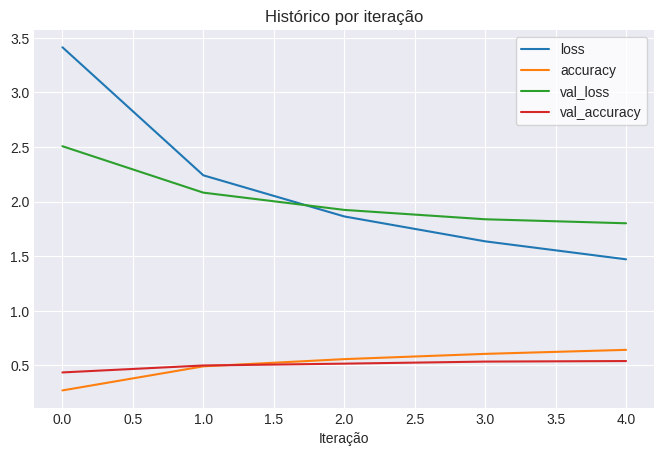

In [21]:
grafico_historico_por_iteracao(historico)

In [23]:
validacao_original = modelo.evaluate(dados_teste)
validacao_original

790/790 [==============================] - 97s 122ms/step - loss: 1.7969 - accuracy: 0.5373


[1.7968957424163818, 0.5373465418815613]